# EM-ML Notebook

## **GDrive**

Define main directory (contains the projects) and project's sub directory

In [ ]:
ml_dir = 'Machine Learning for Vision and Multimedia'

proj_dir = '3'

## Drive mount

In [2]:
import os

drive_path = "fakedrive"
fakedrive = True

try:
    from google.colab import drive
    drive_mount = '/content/drive'
    drive.mount(drive_mount)
    drive_path = os.path.join(drive_mount, 'MyDrive/Colab Notebooks')
    fakedrive = False
    os.chdir(f"{drive_path}/emml")
except ImportError:
    print("Local run")

lab_path = os.path.join(drive_path, ml_dir if not fakedrive else "", proj_dir)

if not os.path.exists(lab_path):
    os.makedirs(lab_path)

data_path = os.path.join(lab_path, 'data')
download = not os.path.exists(data_path) or not os.listdir(data_path)

Local run


## **Imports**

In [20]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from src.utils import count_parameters

## **Dataset**

- `lab_path` is the folder to contain the model and the data for this lab
- `data_path` can be passed to dataset downloaders to save the dataset into the lab path
- boolean `download` is false if the data path folder already esists in current lab dir (created by the downloader)


In [4]:
import kagglehub

# kaggle automatically caches the dataset
kaggle_path = kagglehub.dataset_download("tongpython/cat-and-dog")
print("Path to dataset files:", kaggle_path)


C:\Users\emanuele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\emanuele\.cache\kagglehub\datasets\tongpython\cat-and-dog\versions\1


In [5]:
import shutil
from sklearn.model_selection import train_test_split

train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

kaggle_train_path = os.path.join(kaggle_path, "training_set", "training_set")
kaggle_test_path = os.path.join(kaggle_path, "test_set", "test_set")

# split kaggle train and copy into local data folder

if download: # we don't have the local split already
    
    for label in ['cats', 'dogs']:
        images = os.listdir(os.path.join(kaggle_train_path, label))
        train_images, val_images = train_test_split(images, test_size=0.2)
    
        for img_set, split_dir in [(train_images, train_path), (val_images, val_path)]:
            os.makedirs(os.path.join(split_dir, label), exist_ok=True)
            for img in img_set:
                src = os.path.join(kaggle_train_path, label, img)
                dest = os.path.join(split_dir, label, img)
                shutil.copyfile(src, dest)
        
        # also copy test set locally
        images = os.listdir(os.path.join(kaggle_test_path, label))
        os.makedirs(os.path.join(test_path, label), exist_ok=True)
        for img in images:
            src = os.path.join(kaggle_test_path, label, img)
            dst = os.path.join(test_path, label, img)
            shutil.copyfile(src, dst)
        


In [18]:
from torchvision.models import resnet18, ResNet18_Weights

# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
imagenet_transforms = weights.transforms() # empiric normalization + resize + crop ...

In [21]:
data_augmentation_transforms = transforms.Compose([
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
transforms.RandomRotation(15)])

In [23]:
train_dataset = datasets.ImageFolder(train_path, transform=transforms.Compose([data_augmentation_transforms, imagenet_transforms]))
val_dataset = datasets.ImageFolder(val_path, transform=imagenet_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=imagenet_transforms)

### Inspect

In [25]:
import math

# dataset sizes

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 6403
Validation set size: 1602
Test set size: 2023


Image 3201 shape: torch.Size([3, 224, 224])
Label 3201: 1


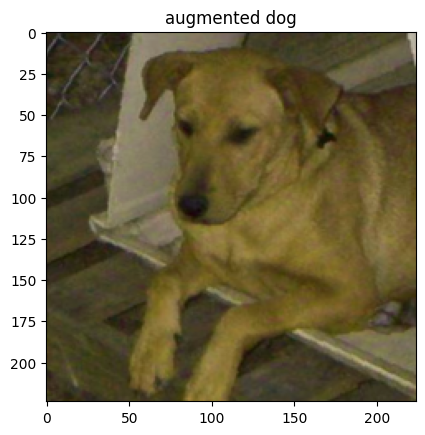

In [29]:
import matplotlib.pyplot as plt
# pick an image

id = math.floor(len(train_dataset)/2)
image, label = train_dataset[id]
print(f"Image {id} shape: {image.shape}")
print(f"Label {id}: {label}")

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

image = image * std[:, None, None] + mean[:, None, None]

plt.title('augmented dog' if label == 1 else 'cat')
plt.imshow(image.permute(1, 2, 0))

## **Models**

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
model.fc = nn.Linear(model.fc.in_features, 2)

In [13]:
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True  # Unfreeze these layers
    else:
        param.requires_grad = False

## **Hyperparams** (Configs)

Define model instances and optimizers

In [14]:
models = {
    'resnet_ft': model,
}

optimizers = {
    'differential_4l': optim.SGD([
        {'params': models['resnet_ft'].layer4.parameters(), 'lr': 1e-4},  # Slower learning rate for layer4
        {'params': models['resnet_ft'].fc.parameters(), 'lr': 1e-3}       # Higher learning rate for the classifier
        ], momentum=0.9) 
}

Register the configs

In [15]:
from src.configs import ConfigManager

configs = ConfigManager(lab_path)

configs.add('resnet_ft', models['resnet_ft'], 
            F.cross_entropy, optimizers['differential_4l'], 
            batch_size=32, epochs=5)

{'resnet_ft': {'model': ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

Choose config for this run

In [16]:
configs.activate('resnet_ft')

Checkpoint: ResNet_81275c6d85


## Dataloader

In [17]:
from src.utils import num_batches

batch_size = configs.active['batch_size']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"# batches train: {num_batches(train_loader)}")
print(f"# batches val: {num_batches(val_loader)}")
print(f"# batches test: {num_batches(test_loader)}")

Batch size: 32
# batches train: 201
# batches val: 201
# batches test: 64


## Training

In [53]:
from src.trainer import Trainer

trainer = Trainer(configs.active)

Using device: cpu


Load previous checkpoint state (optional)

In [54]:
trainer.restore_checkpoint()

Last epoch: 2
Avg loss min: 0.054188690273236355


## **Train**

In [56]:
print("Training...\n")

trainer.train_loop(train_loader, val_loader)

Training...



KeyboardInterrupt: 

## **Test**

In [57]:
print("Test\n")

trainer.test(test_loader)

Test

Eval average loss: 0.0659, Accuracy: 97.5779%


(0.06588821414373797, 97.57785467128028)